In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
matplotlib.rc('figure', figsize=(16, 8))
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels


In [3]:
file_names = [
    'CL=F.csv',
    'UUP.csv',
    'US_GDP_Monthly.csv',
    'us-crude-oil-production-historical-chart.csv',
    'tweet_sentiment_df.csv']

In [4]:
file_path = "../Data/"

In [5]:
cols = ['date', 'close', 'vader compound', 
        'usalorsgpnostsam',
        'world petroleum consumption', 
        'u.s. petroleum consumption',
        'value']

In [6]:
data = pd.DataFrame()

In [7]:
dfs = []
for i in range(len(file_names)):
    file_name = file_path + file_names[i]
    #print(file_name)
    df = pd.read_csv(file_name,
                    parse_dates = True,
                    infer_datetime_format = True)

    df.columns = df.columns.str.lower()

    n = []
    for c in cols:
        if df.columns.str.contains(c).any():
            n.append(df.columns.get_loc(c))
    df = df.iloc[:,n]
    df = df.replace('NaN', np.nan)
    df.dropna()

    #df.dropna()
    try:
        df['date'] = pd.to_datetime(df['date'], infer_datetime_format = True)
    except:
        print(df)
    df = df.set_index('date')

    df.sort_index(inplace = True)
    dfs.append(df)
#    if i == 0:
#        data = df.copy()
#    else:
#        data.join(df, how='outer', rsuffix=str(i))

In [8]:
data = pd.concat(dfs[:-1], join='outer', axis=1)

In [9]:
daily_average = dfs[4].resample('D').mean()

In [10]:
data = data.join(daily_average, how='outer')

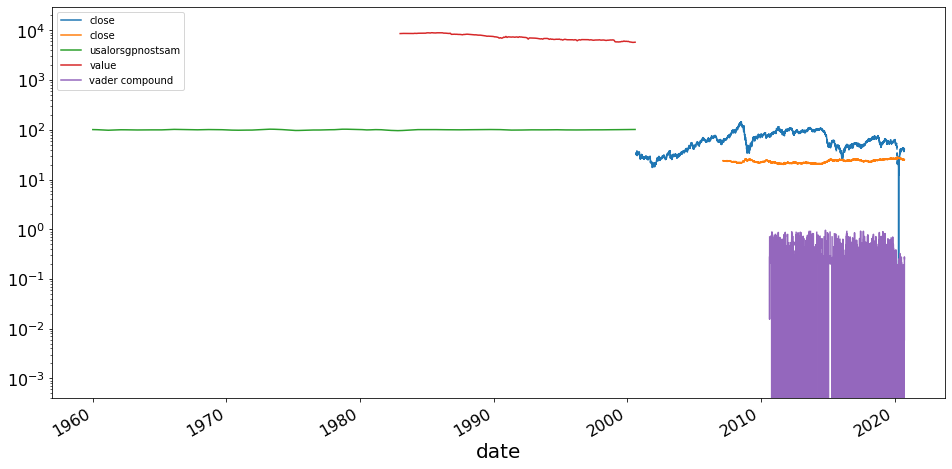

In [11]:
data.plot(logy=True, figsize=(16,8))

In [12]:
df_all = data.interpolate(method ='linear')

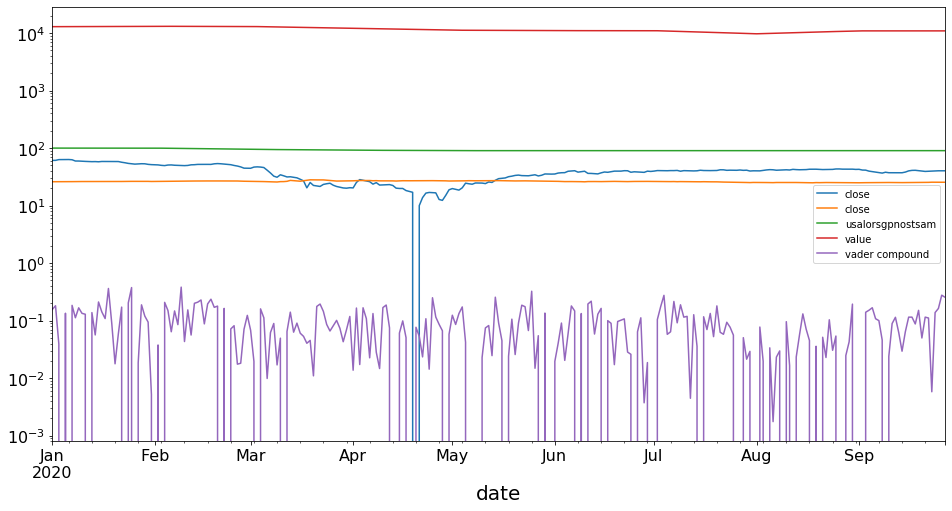

In [13]:
df_all['2020'].plot(logy=True, figsize=(16,8))

In [14]:
df_all.columns

Index(['close', 'close', 'usalorsgpnostsam', 'value', 'vader compound'], dtype='object')

In [15]:
df_all.columns = ['price', 'uup', 'gdp', 'prod', 'vader' ]

In [16]:
df_2 = df_all['2019':'2020']

In [17]:
df_2

,price,uup,gdp,prod,vader
date,,,,,
2019-01-01,45.975000,25.045000,100.075204,11900.000000,0.717625
2019-01-02,46.540000,25.140000,100.074436,11906.451613,-0.285450
2019-01-03,47.090000,25.000000,100.073667,11912.903226,-0.215950
2019-01-04,47.960000,24.960000,100.072898,11919.354839,-0.035650
2019-01-05,48.146667,24.923333,100.072129,11925.806452,-0.425675
...,...,...,...,...,...
2020-09-23,39.930000,25.520000,90.264283,10900.000000,0.005812
2020-09-24,40.310000,25.480000,90.264283,10900.000000,0.138539
2020-09-25,40.310000,25.480000,90.264283,10900.000000,0.163099


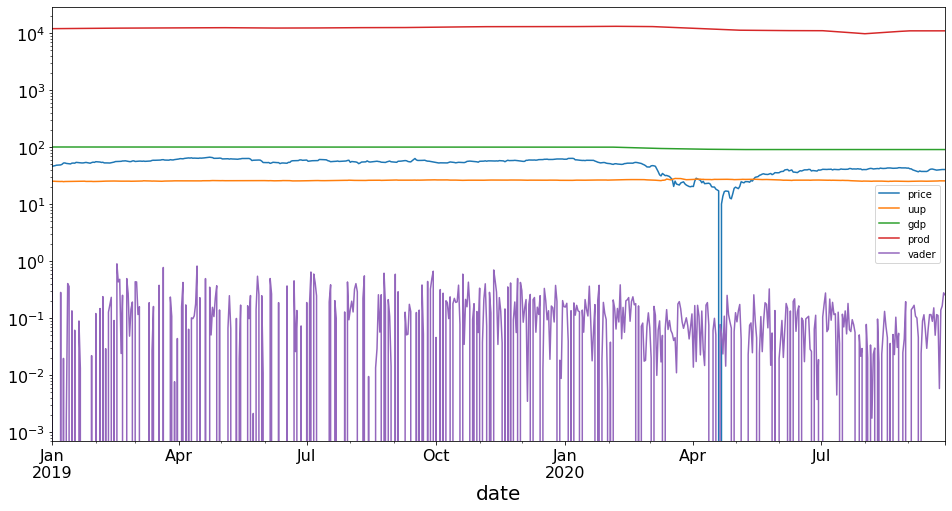

In [18]:
df_2.plot(logy=True, figsize=(16,8))

In [19]:
corr_matrix = df_2.corr(method = "spearman").abs()

In [20]:
import seaborn as sns

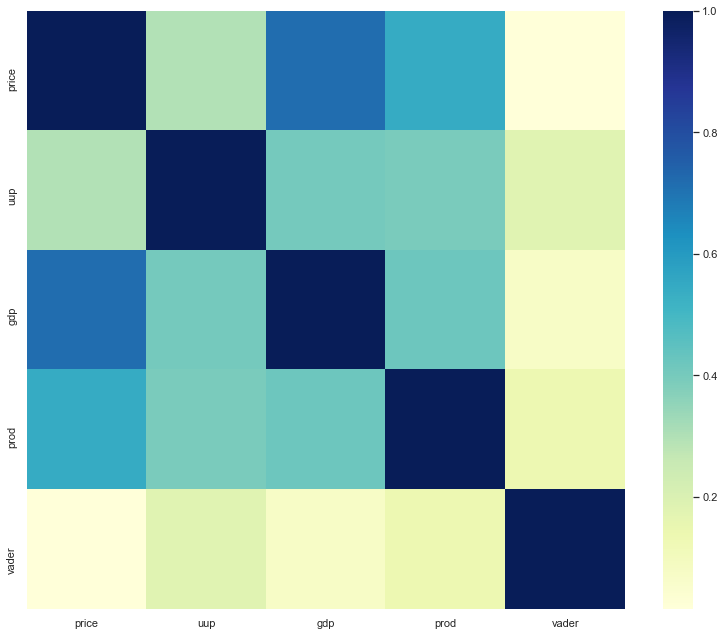

In [21]:
# Draw the heatmap
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()
plt.savefig("correlation_matrix.png")

## Build and Train the LSTM RNN

In [22]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

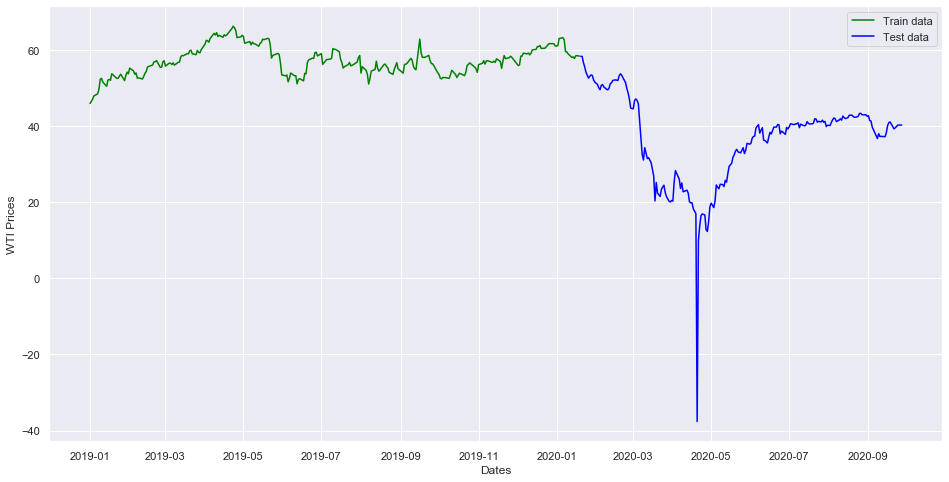

In [23]:
# days for testing
split = 252

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('WTI Prices')
plt.plot(df_2.iloc[:-split, 0], 'green', label='Train data')
plt.plot(df_2.iloc[-split:, 0], 'blue', label='Test data')
plt.legend()

In [24]:
# Predict Closing Prices using a 30 day window of previous closing prices
window_size = 73

# Column index 0 is the `price` column 
target_column = 0

feature_column = 0
X, y = window_data(df_2, window_size, feature_column, target_column)

In [25]:
# 
X_train = X[:-split]
X_test = X[-split:]

y_train = y[:-split]
y_test = y[-split:]

In [26]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.

scaler = MinMaxScaler()
scaler.fit(X)
# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)
# Reshape the features for the model
# YOUR CODE HERE!
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [27]:
# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.80443568]
  [0.80987203]
  [0.81516405]
  [0.82353507]
  [0.82533115]
  [0.82712723]
  [0.82892331]
  [0.84104686]
  [0.86587126]
  [0.86808429]
  [0.85846243]
  [0.85499856]
  [0.85153469]
  [0.84807082]
  [0.86346579]
  [0.86539017]
  [0.86308092]
  [0.87972674]
  [0.87676802]
  [0.87380929]
  [0.87085057]
  [0.86789185]
  [0.86837294]
  [0.87328009]
  [0.87866833]
  [0.87321595]
  [0.86776356]
  [0.86231117]
  [0.87501203]
  [0.88386414]
  [0.87963052]
  [0.89377466]
  [0.89152956]
  [0.88928445]
  [0.88703935]
  [0.87837968]
  [0.88174733]
  [0.86856538]
  [0.86933513]
  [0.86834087]
  [0.86734661]
  [0.86635235]
  [0.87299144]
  [0.88068893]
  [0.88559607]
  [0.89694987]
  [0.8981526 ]
  [0.89935534]
  [0.90055807]
  [0.9017608 ]
  [0.90974695]
  [0.91013182]
  [0.91301838]
  [0.90730941]
  [0.90160044]
  [0.89589147]
  [0.8960839 ]
  [0.90993938]
  [0.9126335 ]
  [0.89897046]
  [0.90150422]
  [0.90403797]
  [0.90657173]
  [0.90628308]
  [0.90301164]
  

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [29]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# YOUR CODE HERE!
model = Sequential()

# Initial model setup
number_units = 55  
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

# Train the model
epochs = 35
batch_size=30
training_history = model.fit(X_train, y_train, 
          epochs=epochs, shuffle=False,
          validation_data=(X_test, y_test),
          batch_size=batch_size, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 73, 55)            12540     
_________________________________________________________________
dropout (Dropout)            (None, 73, 55)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 73, 55)            24420     
_________________________________________________________________
dropout_1 (Dropout)          (None, 73, 55)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 55)                24420     
_________________________________________________________________
dropout_2 (Dropout)          (None, 55)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [30]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)

8/8 [==============================] - 0s 16ms/step - loss: 0.0099


0.009910160675644875

In [31]:
# Make some predictions
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [32]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [33]:
# Create a DataFrame of Real and Predicted values
df_prices = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df_2.index[-len(real_prices): ]) 
df_prices.head()

,Real,Predicted
date,,
2020-01-20,58.44,54.673729
2020-01-21,58.39,54.576283
2020-01-22,58.34,54.486267
2020-01-23,56.74,54.404385
2020-01-24,55.59,54.324787


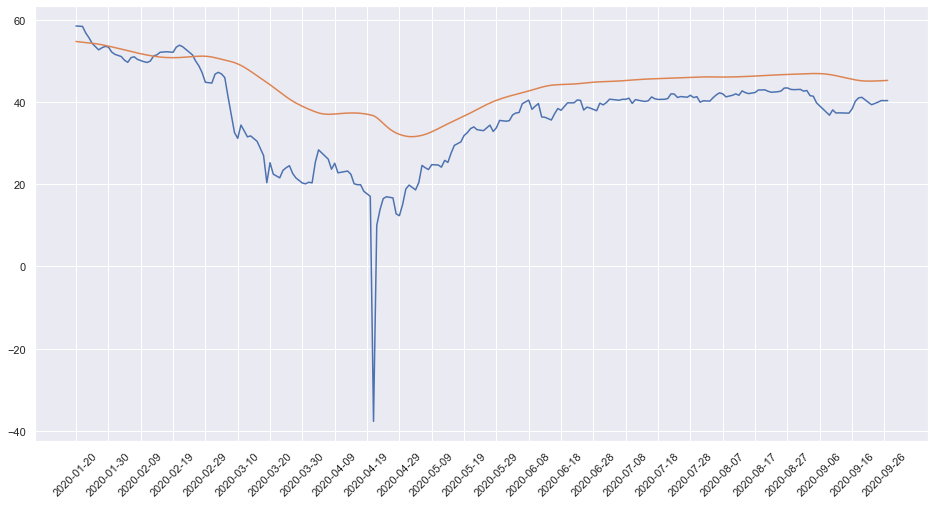

In [34]:
plt.figure(figsize=(16,8))
plt.plot(df_prices)
plt.xticks(df_prices.index[::10],rotation=45)
#plt.legend()
plt.grid(True)
plt.show()

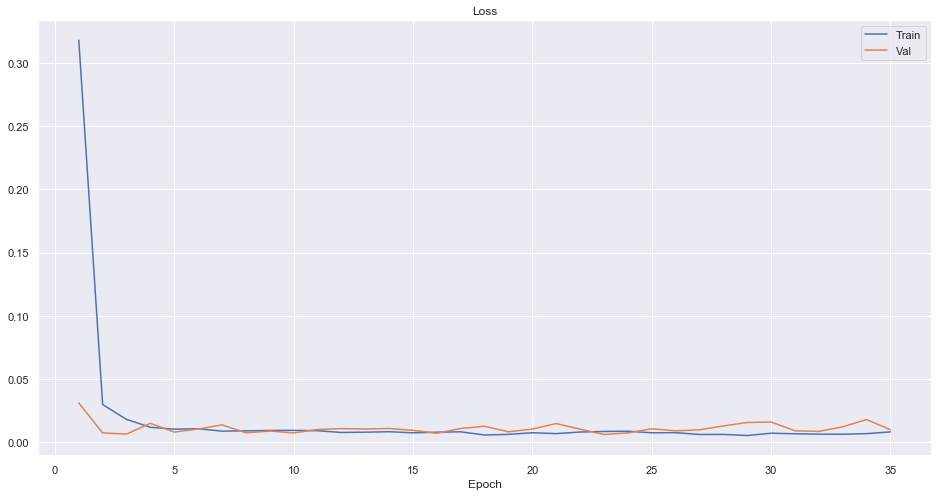

In [35]:
# Plotting loss
loss_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": training_history.history["loss"],
        "Val": training_history.history["val_loss"],
    }
)
loss_df.set_index("Epoch", inplace=True)
loss_df.plot(title="Loss", figsize=(16,8))

In [36]:
oil_df = df_prices.copy()
oil_df['up_down'] = np.nan
# Initialize variable to hold previous price
previous_price = 0
for index, row in oil_df.iterrows():

    if previous_price == 0:
        oil_df.loc[index, "up_down"] = 0
    elif row["Predicted"] < previous_price:
        oil_df.loc[index, "up_down"] = -1
    elif row["Predicted"] > previous_price:
        oil_df.loc[index, "up_down"] = 1
    else:
        oil_df.loc[index, "side"] = 0

    previous_price = row["Predicted"]

# Print the DataFrame
oil_df

,Real,Predicted,up_down
date,,,
2020-01-20,58.44,54.673729,0.0
2020-01-21,58.39,54.576283,-1.0
2020-01-22,58.34,54.486267,-1.0
2020-01-23,56.74,54.404385,-1.0
2020-01-24,55.59,54.324787,-1.0
...,...,...,...
2020-09-23,39.60,45.068378,1.0
2020-09-24,39.93,45.097488,1.0
2020-09-25,40.31,45.132458,1.0


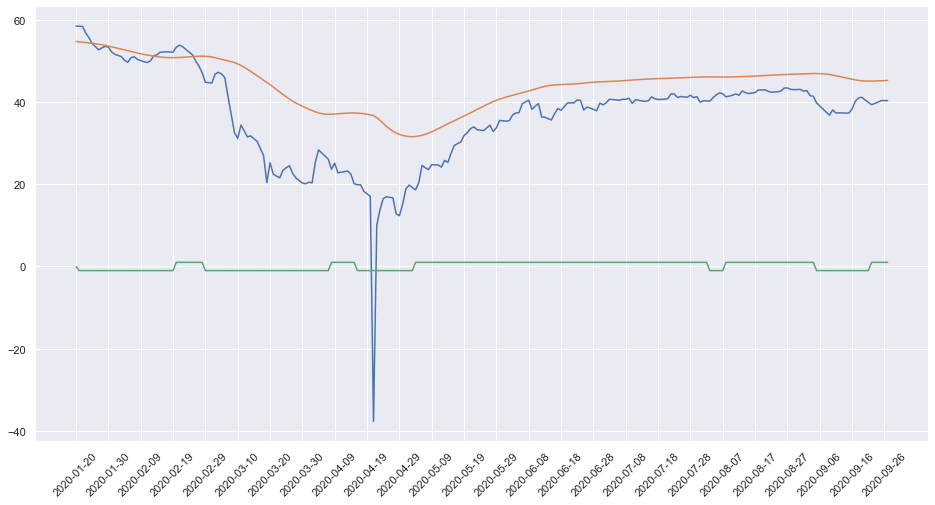

In [37]:
plt.figure(figsize=(16,8))
plt.plot(oil_df)
plt.xticks(oil_df.index[::10],rotation=45)
#plt.legend()
plt.grid(True)
plt.show()

In [38]:
df_2

,price,uup,gdp,prod,vader
date,,,,,
2019-01-01,45.975000,25.045000,100.075204,11900.000000,0.717625
2019-01-02,46.540000,25.140000,100.074436,11906.451613,-0.285450
2019-01-03,47.090000,25.000000,100.073667,11912.903226,-0.215950
2019-01-04,47.960000,24.960000,100.072898,11919.354839,-0.035650
2019-01-05,48.146667,24.923333,100.072129,11925.806452,-0.425675
...,...,...,...,...,...
2020-09-23,39.930000,25.520000,90.264283,10900.000000,0.005812
2020-09-24,40.310000,25.480000,90.264283,10900.000000,0.138539
2020-09-25,40.310000,25.480000,90.264283,10900.000000,0.163099


In [39]:
df_p = df_2.iloc[-len(real_prices):,0].to_frame()
df_p

,price
date,
2020-01-20,58.39
2020-01-21,58.34
2020-01-22,56.74
2020-01-23,55.59
2020-01-24,54.19
...,...
2020-09-23,39.93
2020-09-24,40.31
2020-09-25,40.31


In [40]:
#window_size = 30
target_column = 0 # Column index 0 is the `price` column 
# Use latest 73 days (3 months) for testing
#split = 73

for f_col in df_2.columns:
    #f_col = "uup"
    # Predict Closing Prices using a 30 day window of previous closing prices

    feature_column = df_2.columns.get_loc(f_col)

    X, y = window_data(df_2, window_size, feature_column, target_column)

    X_train = X[:-split]
    X_test = X[-split:]

    y_train = y[:-split]
    y_test = y[-split:]

    scaler.fit(X)
    # Scale the features training and testing sets
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    # Fit the MinMaxScaler object with the target data Y
    scaler.fit(y)

    # Scale the target training and testing sets
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    # Reshape the features for the model
    # YOUR CODE HERE!
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Train the model
    # epochs = 35
    # batch_size=30
    training_history = model.fit(X_train, y_train, 
              epochs=epochs, shuffle=False,
              validation_data=(X_test, y_test),
              batch_size=batch_size, verbose=1)
    #model.fit(X_train, y_train, epochs = 35, batch_size = 30)

    # Evaluate the model
    model.evaluate(X_test, y_test, verbose=1)

    # Make some predictions
    predicted = model.predict(X_test)

    # Recover the original prices instead of the scaled version
    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Create a DataFrame of Real and Predicted values
    p_col = f_col + "_p"

    df_p[p_col] = predicted_prices.ravel()

    u_col = f_col + "_u"
    df_p[u_col] = np.nan
    # Initialize variable to hold previous price
    previous_price = 0
    for index, row in df_p.iterrows():

        if previous_price == 0:
            df_p.loc[index, u_col] = 0
        elif row[p_col] < previous_price:
            df_p.loc[index, u_col] = -1
        elif row[p_col] > previous_price:
            df_p.loc[index, u_col] = 1
        else:
            df_p.loc[index, u_col] = 0

        previous_price = row[p_col]

Epoch 1/35
11/11 [==============================] - 1s 77ms/step - loss: 0.0090 - val_loss: 0.0082
Epoch 2/35
11/11 [==============================] - 1s 72ms/step - loss: 0.0085 - val_loss: 0.0091
Epoch 3/35
11/11 [==============================] - 1s 74ms/step - loss: 0.0072 - val_loss: 0.0135
Epoch 4/35
11/11 [==============================] - 1s 71ms/step - loss: 0.0067 - val_loss: 0.0118
Epoch 5/35
11/11 [==============================] - 1s 74ms/step - loss: 0.0061 - val_loss: 0.0119
Epoch 6/35
11/11 [==============================] - 1s 74ms/step - loss: 0.0058 - val_loss: 0.0129
Epoch 7/35
11/11 [==============================] - 1s 74ms/step - loss: 0.0060 - val_loss: 0.0131
Epoch 8/35
11/11 [==============================] - 1s 102ms/step - loss: 0.0062 - val_loss: 0.0126
Epoch 9/35
11/11 [==============================] - 1s 96ms/step - loss: 0.0042 - val_loss: 0.0149
Epoch 10/35
11/11 [==============================] - 1s 104ms/step - loss: 0.0066 - val_loss: 0.0111
Epoch 1

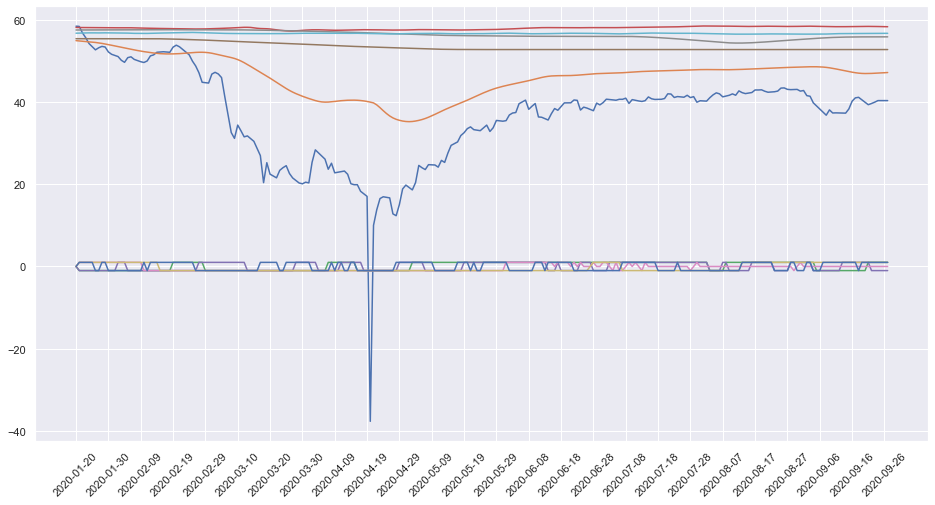

In [41]:
plt.figure(figsize=(16,8))
plt.plot(df_p)
plt.xticks(df_p.index[::10],rotation=45)
#plt.legend()
plt.grid(True)
plt.show()

## Random Forest

In [42]:
df_p

,price,price_p,price_u,uup_p,uup_u,gdp_p,gdp_u,prod_p,prod_u,vader_p,vader_u
date,,,,,,,,,,,
2020-01-20,58.39,54.877983,0.0,58.074615,0.0,55.347721,0.0,57.465691,0.0,56.689545,0.0
2020-01-21,58.34,54.794693,-1.0,58.067745,-1.0,55.347778,1.0,57.468933,1.0,56.715595,1.0
2020-01-22,56.74,54.720161,-1.0,58.062435,-1.0,55.347843,1.0,57.472210,1.0,56.744057,1.0
2020-01-23,55.59,54.654404,-1.0,58.058880,-1.0,55.347908,1.0,57.475529,1.0,56.762302,1.0
2020-01-24,54.19,54.590900,-1.0,58.057930,-1.0,55.347969,1.0,57.478870,1.0,56.767380,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-09-23,39.93,46.953175,1.0,58.324387,-1.0,52.712341,0.0,55.800362,1.0,56.627522,1.0
2020-09-24,40.31,46.994747,1.0,58.308655,-1.0,52.712341,0.0,55.801254,1.0,56.637440,1.0
2020-09-25,40.31,47.038128,1.0,58.285332,-1.0,52.712341,0.0,55.801800,1.0,56.650127,1.0


In [43]:
df_p['daily_return'] = df_p['price'].pct_change()
df_p

,price,price_p,price_u,uup_p,uup_u,gdp_p,gdp_u,prod_p,prod_u,vader_p,vader_u,daily_return
date,,,,,,,,,,,,
2020-01-20,58.39,54.877983,0.0,58.074615,0.0,55.347721,0.0,57.465691,0.0,56.689545,0.0,NaN
2020-01-21,58.34,54.794693,-1.0,58.067745,-1.0,55.347778,1.0,57.468933,1.0,56.715595,1.0,-0.000856
2020-01-22,56.74,54.720161,-1.0,58.062435,-1.0,55.347843,1.0,57.472210,1.0,56.744057,1.0,-0.027425
2020-01-23,55.59,54.654404,-1.0,58.058880,-1.0,55.347908,1.0,57.475529,1.0,56.762302,1.0,-0.020268
2020-01-24,54.19,54.590900,-1.0,58.057930,-1.0,55.347969,1.0,57.478870,1.0,56.767380,1.0,-0.025184
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-23,39.93,46.953175,1.0,58.324387,-1.0,52.712341,0.0,55.800362,1.0,56.627522,1.0,0.008333
2020-09-24,40.31,46.994747,1.0,58.308655,-1.0,52.712341,0.0,55.801254,1.0,56.637440,1.0,0.009517
2020-09-25,40.31,47.038128,1.0,58.285332,-1.0,52.712341,0.0,55.801800,1.0,56.650127,1.0,0.000000


In [44]:
trading_signals_df = df_p

In [45]:
# Set x variable list of features
x_var_list = ['price_u', 'uup_u', 'gdp_u', 'prod_u', 'vader_u']

# Filter by x-variable list
trading_signals_df[x_var_list].tail()

,price_u,uup_u,gdp_u,prod_u,vader_u
date,,,,,
2020-09-23,1.0,-1.0,0.0,1.0,1.0
2020-09-24,1.0,-1.0,0.0,1.0,1.0
2020-09-25,1.0,-1.0,0.0,1.0,1.0
2020-09-26,1.0,-1.0,0.0,1.0,1.0
2020-09-27,1.0,-1.0,0.0,1.0,1.0


In [46]:
# Shift DataFrame values by 1
trading_signals_df[x_var_list] = trading_signals_df[x_var_list].shift(1)
trading_signals_df[x_var_list].tail()

,price_u,uup_u,gdp_u,prod_u,vader_u
date,,,,,
2020-09-23,1.0,-1.0,0.0,1.0,1.0
2020-09-24,1.0,-1.0,0.0,1.0,1.0
2020-09-25,1.0,-1.0,0.0,1.0,1.0
2020-09-26,1.0,-1.0,0.0,1.0,1.0
2020-09-27,1.0,-1.0,0.0,1.0,1.0


In [ ]:
# Drop NAs and replace positive/negative infinity values
trading_signals_df.dropna(subset=x_var_list, inplace=True)
trading_signals_df.dropna(subset=['daily_return'], inplace=True)
trading_signals_df = trading_signals_df.replace([np.inf, -np.inf], np.nan)
trading_signals_df.head()

In [ ]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
trading_signals_df['Positive Return'] = np.where(trading_signals_df['daily_return'] > 0, 1.0, 0.0)
trading_signals_df

In [ ]:
# Construct training start and end dates
training_start = trading_signals_df.index.min().strftime(format= '%Y-%m-%d')
training_end = '2020-08-14'

# Construct testing start and end dates
testing_start =  '2020-08-15'
testing_end = trading_signals_df.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

In [50]:
# Construct the X_train and y_train datasets
X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df['Positive Return'][training_start:training_end]

X_train.tail()

,price_u,uup_u,gdp_u,prod_u,vader_u
date,,,,,
2020-08-10,1.0,-1.0,0.0,-1.0,-1.0
2020-08-11,1.0,-1.0,0.0,-1.0,-1.0
2020-08-12,1.0,-1.0,0.0,-1.0,-1.0
2020-08-13,1.0,-1.0,0.0,-1.0,-1.0
2020-08-14,1.0,-1.0,0.0,1.0,1.0


In [51]:
y_train.tail()

date
2020-08-10    1.0
2020-08-11    0.0
2020-08-12    1.0
2020-08-13    0.0
2020-08-14    0.0
Name: Positive Return, dtype: float64

In [52]:
# Construct the X test and y test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df['Positive Return'][testing_start:testing_end]

X_test.tail()

,price_u,uup_u,gdp_u,prod_u,vader_u
date,,,,,
2020-09-23,1.0,-1.0,0.0,1.0,1.0
2020-09-24,1.0,-1.0,0.0,1.0,1.0
2020-09-25,1.0,-1.0,0.0,1.0,1.0
2020-09-26,1.0,-1.0,0.0,1.0,1.0
2020-09-27,1.0,-1.0,0.0,1.0,1.0


In [53]:
y_test.tail()

date
2020-09-23    1.0
2020-09-24    1.0
2020-09-25    0.0
2020-09-26    0.0
2020-09-27    0.0
Name: Positive Return, dtype: float64

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [55]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

,Positive Return,Predicted Value
date,,
2020-08-15,1.0,0.0
2020-08-16,1.0,0.0
2020-08-17,1.0,0.0
2020-08-18,0.0,0.0
2020-08-19,1.0,0.0
2020-08-20,0.0,0.0
2020-08-21,0.0,0.0
2020-08-22,1.0,0.0
2020-08-23,1.0,0.0


In [56]:
Results.rename(columns={"Positive Return": "Actual Value"}, inplace=True)

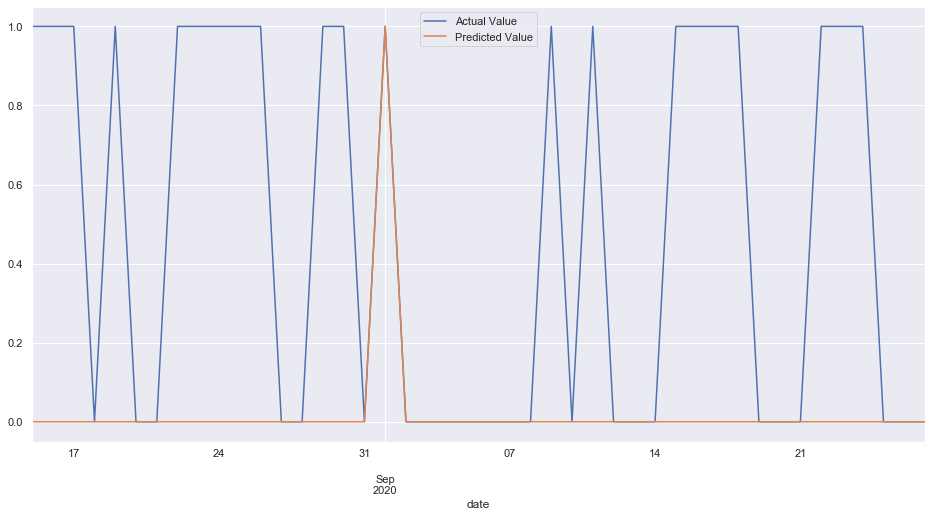

In [57]:
# Plot predicted results vs. actual results
Results[['Actual Value', 'Predicted Value']].plot(figsize=(16,8))

In [58]:
results = pd.concat([Results, trading_signals_df[['price','daily_return']]], 
                    axis=1,
                   join='inner')
results

,Actual Value,Predicted Value,price,daily_return
date,,,,
2020-08-15,1.0,0.0,42.140000,0.003095
2020-08-16,1.0,0.0,42.270000,0.003085
2020-08-17,1.0,0.0,42.890000,0.014668
2020-08-18,0.0,0.0,42.890000,0.000000
2020-08-19,1.0,0.0,42.930000,0.000933
2020-08-20,0.0,0.0,42.580000,-0.008153
2020-08-21,0.0,0.0,42.340000,-0.005636
2020-08-22,1.0,0.0,42.400000,0.001417
2020-08-23,1.0,0.0,42.460000,0.001415


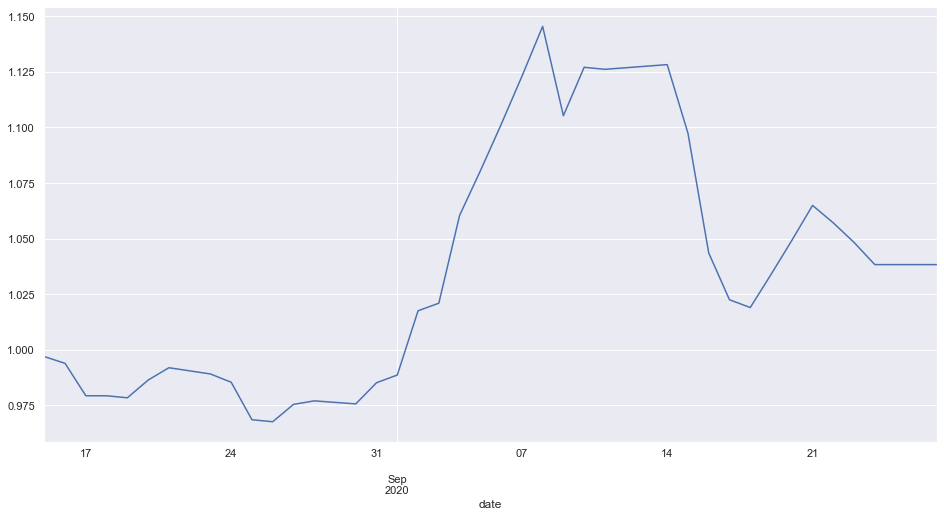

In [59]:
# Replace predicted values 0 to -1 to account for shorting
results['Predicted Value'].replace(0, -1, inplace=True)

# Calculate cumulative return of model and plot the result
(1 + (results['daily_return'] * results['Predicted Value'])).cumprod().plot(figsize=(16,8))

## Model Evaluation

In [60]:
from sklearn.metrics import (confusion_matrix, 
                             accuracy_score, 
                             classification_report)

In [61]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)


In [62]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,23,0
Actual 1,20,1


Accuracy Score : 0.5454545454545454
Classification Report
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.70        23
         1.0       1.00      0.05      0.09        21

    accuracy                           0.55        44
   macro avg       0.77      0.52      0.39        44
weighted avg       0.76      0.55      0.41        44



## Feature Importance

In [63]:
# Random Forests in sklearn will automatically calculate feature importance
importances = model.feature_importances_

In [64]:
# We can sort the features by their importance
sorted(zip(model.feature_importances_, X_train.columns), reverse=True)

[(0.34348674658813116, 'gdp_u'),
 (0.27294247279034817, 'price_u'),
 (0.14358135088799498, 'prod_u'),
 (0.12052109966275149, 'vader_u'),
 (0.11946833007077418, 'uup_u')]

In [65]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_, 
                                         X_train.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')

In [66]:
importances_sorted

,Feature Importances
1,
uup_u,0.119468
vader_u,0.120521
prod_u,0.143581
price_u,0.272942
gdp_u,0.343487


In [68]:
importances_sorted.index = ['UUP', 'Twitter Vader', 'Production', 'Historical Prices', 'US GDP']

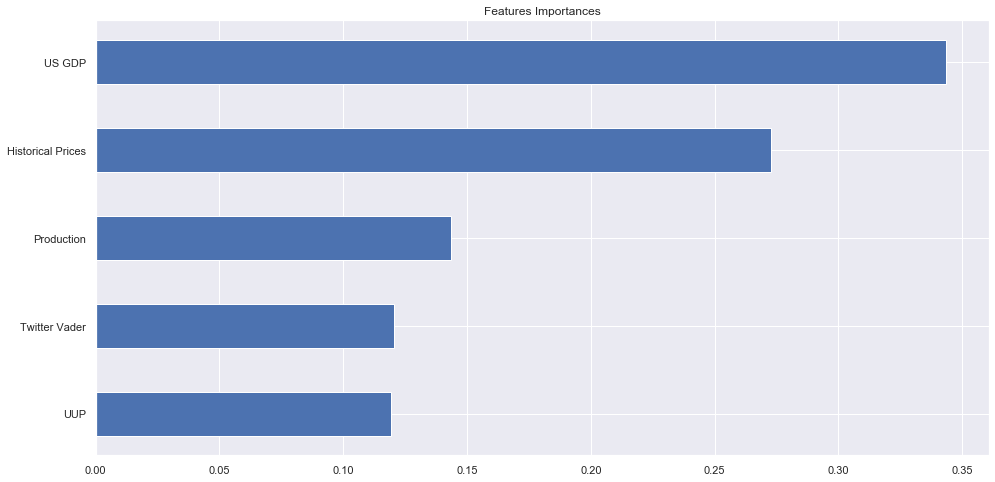

In [69]:
plt.figure(figsize=(16,8))
plt.barh(importances_sorted.index,
        importances_sorted['Feature Importances'],
        height=0.5)
plt.title('Features Importances')
plt.show()